# Homework 4: Clustering by Blake Zurman

## Setup

###  Step 1: Load the 20 Newsgroups Data

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. You can find additional information here:

In [1]:
from sklearn.datasets import fetch_20newsgroups

# You can load just a subset of categories for simplicity
categories = ['talk.religion.misc','alt.atheism','soc.religion.christian']

# Load the training data
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

In [5]:
# Example of accessing the data
print(newsgroups_train.data[0])
print(newsgroups_train.target[0])  # Corresponding target to the above document

# The size of the dataset can be found by checking the length of the data list
print(f"Training set size: {len(newsgroups_train.data)}")

From: jayne@mmalt.guild.org (Jayne Kulikauskas)
Subject: Re: Can sin "block" our prayers?
Organization: Kulikauskas home
Lines: 27

mike@boulder.snsc.unr.edu (Mike McCormick) writes:

> Not honoring our wives can cause our prayers to be hindered:
> 
>         You husbands likewise, live with your wives in
>         an understanding way, as with a weaker vessel,
>         since she is a woman;  and grant her honor as
>         a fellow heir of the grace of life, so that your
>         prayers may not be hindered.  I Peter 3:7

One interpretation I've heard of this verse is that it refers to the sin 
of physically abusing one's wife.  The husband is usually physically 
stronger than his wife but is not permitted to use this to dominate her.  
He must honor her as his sister in Christ.  This would therefore be an 
example of a specific sin that blocks prayer.

This verse also makes me think of the kind of husband who decides what 
is God's will for his family without consulting his wife. 

### Step 2:  Vectorize our data

We need to turn our text into sets of words.  However, we don't want words that are either too frequent or infrequent.  To do this, we'll use the TF-IDF vectorizer, and pick the top N (up to you!) words.

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Sample data
documents = newsgroups_train.data

# Initialize the TFIDF vectorizer
vectorizer = TfidfVectorizer(stop_words="english")

# Fit the model and transform the documents
tfidf_matrix = vectorizer.fit_transform(documents)

print(vectorizer)

# Get the feature names
feature_names = vectorizer.get_feature_names_out()

# Get the TF-IDF scores for each feature
# Here, we sum the scores for each term across all documents
sums = tfidf_matrix.sum(axis=0)

# Connecting term to its sums score
data = []
for col, term in enumerate(feature_names):
    data.append((term, sums[0,col]))

# Create a DataFrame with the terms and their scores
ranking = pd.DataFrame(data, columns=['term','rank'])
ranking = ranking.sort_values('rank', ascending=False)

# Select top N terms
top_n = 1000
top_n_terms = ranking.head(top_n)
print(top_n_terms)

TfidfVectorizer(stop_words='english')
            term       rank
8230         edu  54.141299
10292        god  50.703659
5671         com  36.943917
16372     people  31.206464
12551      jesus  27.993130
...          ...        ...
8898    examples   2.508613
18289    related   2.506292
17433   prophets   2.501462
9648   followers   2.498626
8576    entirely   2.497467

[1000 rows x 2 columns]


### Step 3: Join your terms with the Glove Vectors

GloVe vectors are word embeddings produced by the GloVe model, developed at Stanford. You can find them in the [Stanford GloVe repository](https://nlp.stanford.edu/projects/glove/). You'll probably want the smallest one (glove.6B). Once you have the embeddings, you’ll need to map these vectors to your data — keep in mind that the vectors come in different dimensions. I’ll use the 100-dimensional vectors for demonstration purposes.

In [53]:
# this code block is useful if you are working in a remote environment, such as Colab
# note that the download may take a while
! wget https://nlp.stanford.edu/data/glove.6B.zip
! unzip glove.6B.zip

zsh:1: command not found: wget
Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [59]:
import numpy as np

# Load GloVe vectors into a dictionary:
glove_vectors = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_vectors[word] = vector

In [65]:
original_feature_names = top_n_terms.term

# Note that not all features are present in the glove vectors, so we'll filter here:
word_vectors = []
filtered_feature_names = []

for word in original_feature_names:
    if word in glove_vectors:
        word_vectors.append(glove_vectors[word])
        filtered_feature_names.append(word)

# Convert the list of vectors to a numpy array
word_vectors = np.array(word_vectors)

Matplotlib created a temporary cache directory at /var/folders/_3/l3p32sr93qxcl98qdj6_4pg40000gn/T/matplotlib-oz7e007l because the default path (/Users/blakezurman/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


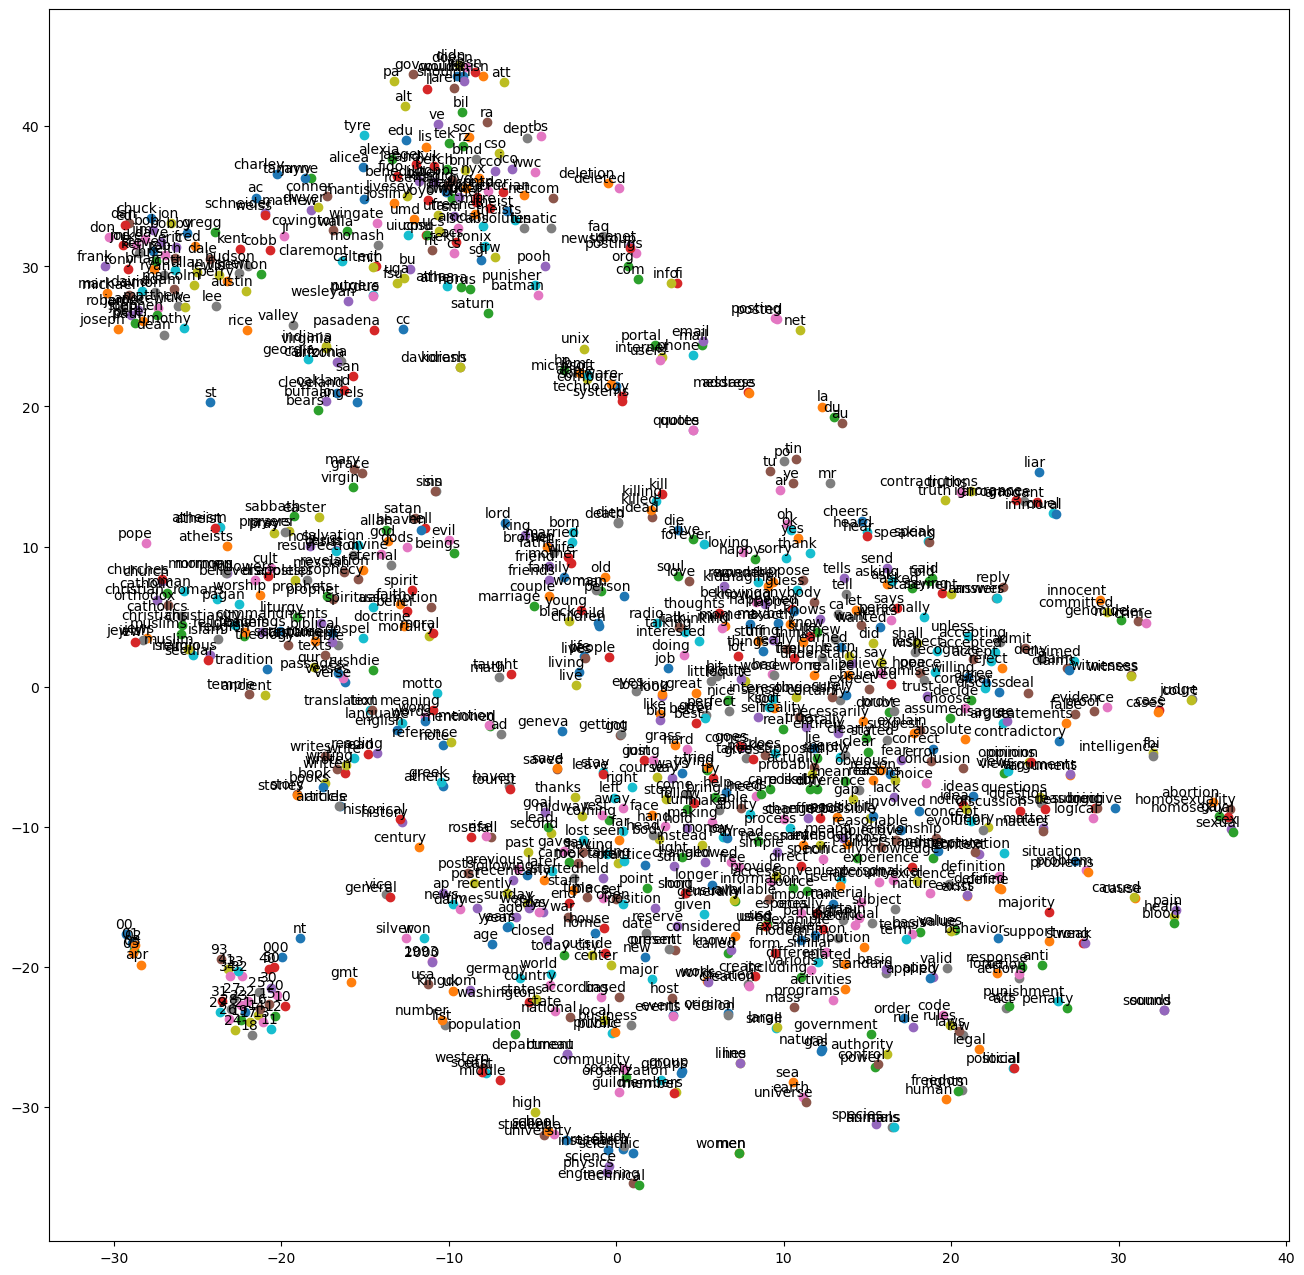

In [67]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Use t-SNE to project the vectors into a 2D space
tsne = TSNE(n_components=2)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Plot the projection
plt.figure(figsize=(16, 16))
for i, word in enumerate(filtered_feature_names):
    if word in glove_vectors:  # Only plot words that were in the GloVe vectors
        plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
        plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom')
plt.show()

## Markdown Explaination

In the following markdown blocks, each code block will have a choice of one reduction method, and one clustering method

## PCA and KMeans

Silhouette Score without PCA: 0.0068985352154652645
Silhouette Score with PCA: 0.16133901593139105


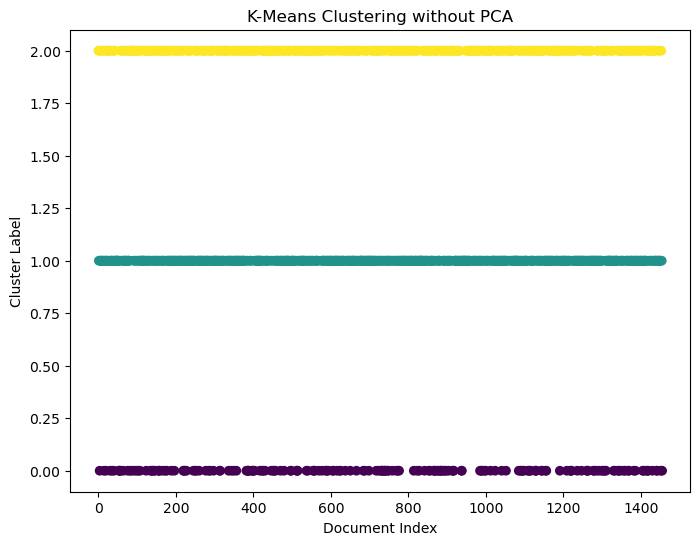

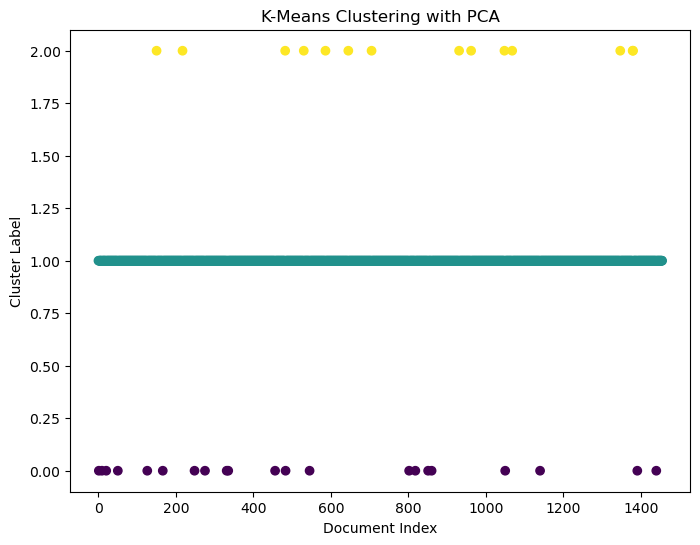

In [69]:
# I will compare the results of clustering after dimensionality reduction versus clustering without dimensionality reduction.

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Step 1.1: Apply K-Means clustering without dimensionality reduction
kmeans_no_pca = KMeans(n_clusters=3, random_state=42)
kmeans_no_pca.fit(tfidf_matrix)

# Step 1.1: Evaluate the clustering using silhouette score
silhouette_no_pca = silhouette_score(tfidf_matrix, kmeans_no_pca.labels_)
print(f"Silhouette Score without PCA: {silhouette_no_pca}")

# Step 1.2: Apply PCA for dimensionality reduction (e.g., reduce to 50 dimensions)
pca = PCA(n_components=50)
pca_matrix = pca.fit_transform(tfidf_matrix.toarray())

# Step 1.2: Apply K-Means clustering to the reduced data (after PCA)
kmeans_pca = KMeans(n_clusters=3, random_state=42)
kmeans_pca.fit(pca_matrix)

# Step 1.2: Evaluate the clustering using silhouette score
silhouette_pca = silhouette_score(pca_matrix, kmeans_pca.labels_)
print(f"Silhouette Score with PCA: {silhouette_pca}")

# Optional: Plotting the clusters for both methods
import matplotlib.pyplot as plt

# Plot for clustering without PCA
plt.figure(figsize=(8, 6))
plt.scatter(range(len(kmeans_no_pca.labels_)), kmeans_no_pca.labels_, c=kmeans_no_pca.labels_, cmap='viridis')
plt.title('K-Means Clustering without PCA')
plt.xlabel('Document Index')
plt.ylabel('Cluster Label')
plt.show()

# Plot for clustering with PCA
plt.figure(figsize=(8, 6))
plt.scatter(range(len(kmeans_pca.labels_)), kmeans_pca.labels_, c=kmeans_pca.labels_, cmap='viridis')
plt.title('K-Means Clustering with PCA')
plt.xlabel('Document Index')
plt.ylabel('Cluster Label')
plt.show()


## PCA and K-Means Analysis
- Clustering without PCA had a low silhouette score (0.0069), indicating poor cluster separation.
- Clustering with PCA showed an improved silhouette score (0.1613), suggesting dimensionality reduction helps K-Means find better-defined clusters.
- Thus, projecting the data with PCA before clustering leads to better performance.


## HAC and UMAP

Silhouette Score for UMAP + HAC Clustering: 0.38785216212272644


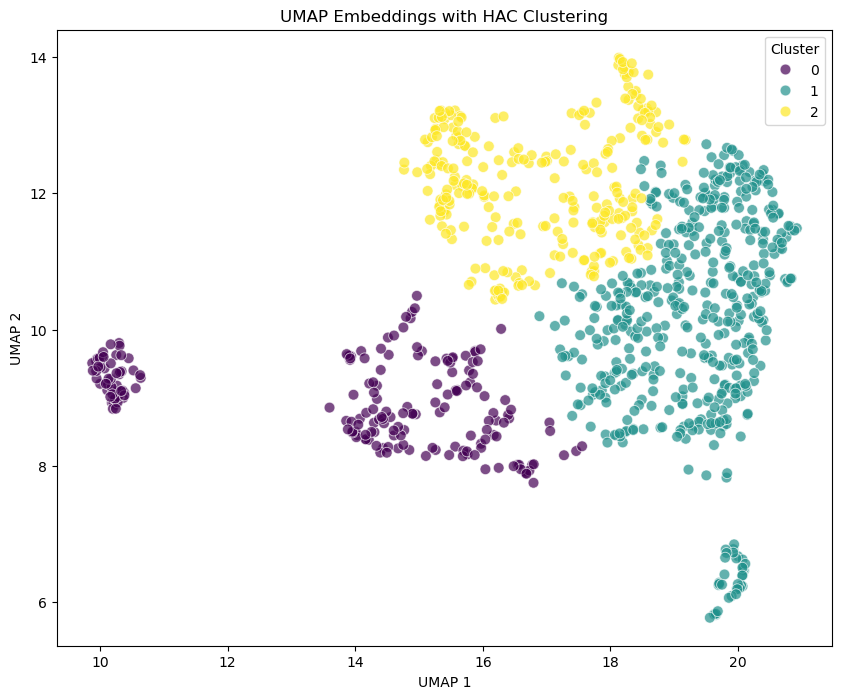

Cluster Distribution: 
1    482
2    277
0    206
Name: count, dtype: int64

Cluster 0:
edu, com, don, keith, university, sandvik, caltech, nntp, cs, sgi

Cluster 1:
lines, organization, think, know, just, believe, say, does, like, time

Cluster 2:
god, people, jesus, writes, subject, article, christian, bible, christians, church

Cluster Summaries:
Cluster 0:
  - Major terms: edu, com, don, keith, university, sandvik, caltech, nntp, cs, sgi
Cluster 1:
  - Major terms: lines, organization, think, know, just, believe, say, does, like, time
Cluster 2:
  - Major terms: god, people, jesus, writes, subject, article, christian, bible, christians, church


In [91]:
# Import necessary libraries
from sklearn.metrics import silhouette_score
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import umap

# Perform UMAP dimensionality reduction
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine')
umap_embeddings = umap_model.fit_transform(word_vectors)

# Perform Hierarchical Agglomerative Clustering (HAC)
hac = AgglomerativeClustering(n_clusters=3)  # You can adjust the number of clusters
hac_labels = hac.fit_predict(umap_embeddings)

# Calculate Silhouette Score for HAC + UMAP clustering
silhouette_umap_hac = silhouette_score(umap_embeddings, hac_labels)
print(f"Silhouette Score for UMAP + HAC Clustering: {silhouette_umap_hac}")

# Visualize the UMAP embeddings colored by HAC clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=hac_labels, palette='viridis', s=60, edgecolor='w', alpha=0.7)
plt.title('UMAP Embeddings with HAC Clustering')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Cluster', loc='best')
plt.show()

# Optional: Show the distribution of documents in each cluster
cluster_distribution = pd.Series(hac_labels).value_counts()
print(f"Cluster Distribution: \n{cluster_distribution}")

# Analyze clusters by identifying top terms (you can adjust the terms per cluster)
# Group words by HAC clusters
cluster_terms = {i: [] for i in range(len(set(hac_labels)))}
for idx, label in enumerate(hac_labels):
    cluster_terms[label].append(filtered_feature_names[idx])

# Display terms per cluster
for cluster, terms in cluster_terms.items():
    print(f"\nCluster {cluster}:")
    print(", ".join(terms[:10]))  # Show top 10 terms for each cluster (you can adjust)

# Summarize clusters
cluster_summary = []
for cluster, terms in cluster_terms.items():
    cluster_summary.append(f"Cluster {cluster}:")
    common_terms = ", ".join(terms[:10])  # Summarize the top terms
    cluster_summary.append(f"  - Major terms: {common_terms}")

print("\nCluster Summaries:")
print("\n".join(cluster_summary))



## Analysis of HAC and UMAP

I'm just ignoring the 'edu' and 'com' terms that keep coming up.

Cluster 0 is characterized by terms related to universities, technology, and academic organizations, 
indicating that the cluster might represent discussions or content related to education, technology, and institutions.
Major terms: 'don', 'keith', 'university', 'sandvik', 'caltech', 'nntp', 'cs', 'sgi'

Cluster 1 contains terms that reflect thinking, belief, and communication, 
suggesting that this cluster might represent general discussions or topics related to ideas, opinions, and philosophy.
Major terms: 'lines', 'organization', 'think', 'know', 'just', 'believe', 'say', 'does', 'like', 'time'

Cluster 2 focuses on terms related to religion, particularly Christianity, 
which indicates that this cluster might represent discussions about faith, spirituality, or religious topics.
Major terms: 'god', 'people', 'jesus', 'writes', 'subject', 'article', 'christian', 'bible', 'christians', 'church'

In summary, these clusters represent different thematic groups:
- Cluster 0: Education and technology-related content
- Cluster 1: Philosophical or opinion-based discussions
- Cluster 2: Religious content related to Christianity


## PCA and HDBSCAM

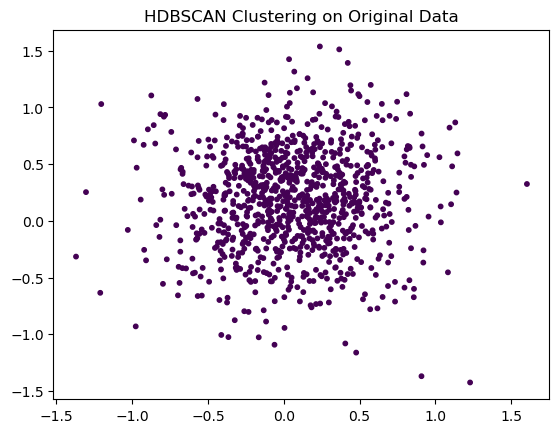

No valid clusters found in the original data.


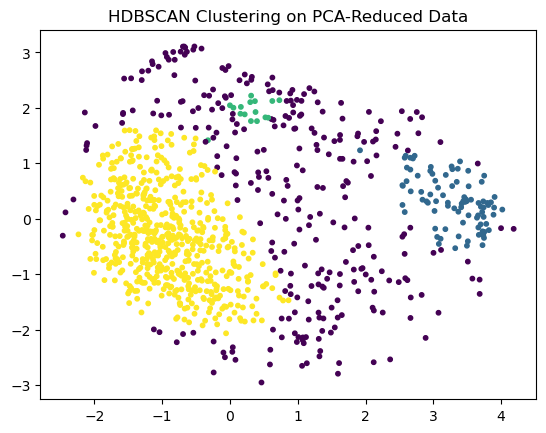

Silhouette Score for PCA-Reduced Data + HDBSCAN Clustering: 0.5339378714561462


In [112]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import hdbscan
import numpy as np

# Assuming word_vectors is your data matrix (with shape: n_samples x n_features)

# HDBSCAN clustering on original high-dimensional data
hdbscan_clusterer_original = hdbscan.HDBSCAN(min_samples=50, gen_min_span_tree=True)
hdbscan_labels_original = hdbscan_clusterer_original.fit_predict(word_vectors)

# Visualize the original clustering (before PCA)
plt.scatter(word_vectors[:, 0], word_vectors[:, 1], c=hdbscan_labels_original, cmap='viridis', s=10)
plt.title("HDBSCAN Clustering on Original Data")
plt.show()

# Check if there are valid labels (non-noise clusters)
valid_labels_original = hdbscan_labels_original != -1
if valid_labels_original.any():
    silhouette_hdbscan_original = silhouette_score(word_vectors[valid_labels_original], hdbscan_labels_original[valid_labels_original])
    print(f"Silhouette Score for Original Data + HDBSCAN Clustering: {silhouette_hdbscan_original}")
else:
    print("No valid clusters found in the original data.")

# Perform PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)

# HDBSCAN clustering on PCA-reduced data
hdbscan_clusterer_pca = hdbscan.HDBSCAN(min_samples=50, gen_min_span_tree=True)
hdbscan_labels_pca = hdbscan_clusterer_pca.fit_predict(word_vectors_pca)

# Visualize the clustering on PCA-reduced data
plt.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1], c=hdbscan_labels_pca, cmap='viridis', s=10)
plt.title("HDBSCAN Clustering on PCA-Reduced Data")
plt.show()

# Check if there are valid labels (non-noise clusters) for PCA-reduced data
valid_labels_pca = hdbscan_labels_pca != -1
if valid_labels_pca.any():
    silhouette_hdbscan_pca = silhouette_score(word_vectors_pca[valid_labels_pca], hdbscan_labels_pca[valid_labels_pca])
    print(f"Silhouette Score for PCA-Reduced Data + HDBSCAN Clustering: {silhouette_hdbscan_pca}")
else:
    print("No valid clusters found in the PCA-reduced data.")


## Projecting Before Clustering
Before PCA, i couldn't even get a valid cluster, but after i got a sil score of .53 which is good.
I'm going to just reduce before I cluster in the following code

## UMAP and HDBSCAN

Silhouette Score for UMAP + HDBSCAN Clustering: 0.556249737739563


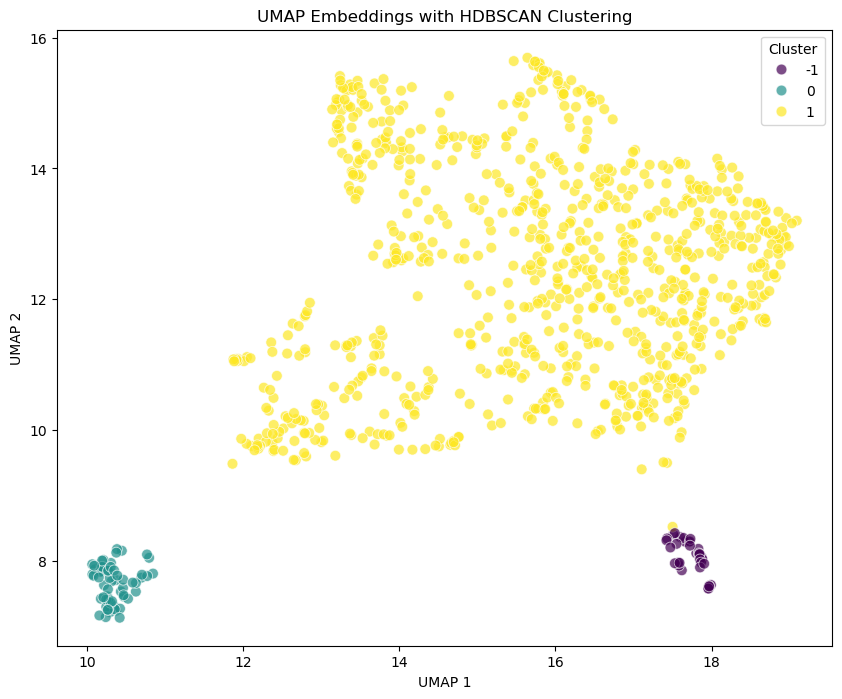

Cluster Distribution: 
 1    869
 0     61
-1     35
Name: count, dtype: int64

Cluster 0:
don, keith, kent, john, jim, jon, paul, david, newton, frank

Cluster 1:
edu, god, com, people, jesus, writes, subject, lines, organization, article

Cluster Summaries:
Cluster 0:
  - Major terms: don, keith, kent, john, jim, jon, paul, david, newton, frank
Cluster 1:
  - Major terms: edu, god, com, people, jesus, writes, subject, lines, organization, article


In [108]:
# Import necessary libraries
import hdbscan
from sklearn.metrics import silhouette_score
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import umap

# Perform UMAP dimensionality reduction
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine')
umap_embeddings = umap_model.fit_transform(word_vectors)

# Perform HDBSCAN clustering
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=50, metric='euclidean')  # You can adjust the parameters
hdbscan_labels = hdbscan_model.fit_predict(umap_embeddings)

# Calculate Silhouette Score for UMAP + HDBSCAN clustering
# Only compute silhouette score for non-noise points (-1 means noise in HDBSCAN)
valid_labels = hdbscan_labels != -1
silhouette_hdbscan_umap = silhouette_score(umap_embeddings[valid_labels], hdbscan_labels[valid_labels])
print(f"Silhouette Score for UMAP + HDBSCAN Clustering: {silhouette_hdbscan_umap}")

# Visualize the UMAP embeddings colored by HDBSCAN clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=hdbscan_labels, palette='viridis', s=60, edgecolor='w', alpha=0.7)
plt.title('UMAP Embeddings with HDBSCAN Clustering')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Cluster', loc='best')
plt.show()

# Optional: Show the distribution of documents in each cluster (excluding noise points)
cluster_distribution = pd.Series(hdbscan_labels).value_counts()
print(f"Cluster Distribution: \n{cluster_distribution}")

# Analyze clusters by identifying top terms (you can adjust the terms per cluster)
# Group words by HDBSCAN clusters
cluster_terms = {i: [] for i in set(hdbscan_labels) if i != -1}  # Exclude noise (-1)
for idx, label in enumerate(hdbscan_labels):
    if label != -1:  # Exclude noise points
        cluster_terms[label].append(filtered_feature_names[idx])

# Display terms per cluster
for cluster, terms in cluster_terms.items():
    print(f"\nCluster {cluster}:")
    print(", ".join(terms[:10]))  # Show top 10 terms for each cluster (you can adjust)

# Summarize clusters
cluster_summary = []
for cluster, terms in cluster_terms.items():
    cluster_summary.append(f"Cluster {cluster}:")
    common_terms = ", ".join(terms[:10])  # Summarize the top terms
    cluster_summary.append(f"  - Major terms: {common_terms}")

print("\nCluster Summaries:")
print("\n".join(cluster_summary))


## Analysis of UMAP and HBDSCAN

Cluster Distribution:
- Cluster 0: 63 documents (personal, informal content with names like "don", "keith", "kent", etc.)
- Cluster 1: 866 documents (religious, educational, and formal terms like "god", "jesus", "writes", etc.). maybe talking about what jesus or god says or writes.
- Noise (-1): 36 documents (likely outliers or irrelevant content that doesn't fit into any cluster)
 
Cluster 0: Major terms include personal names (don, keith, kent, john, jim).
Cluster 1: Major terms related to religion, education, and formal language, indicating more structured discussions on these topics.

Conclusion:
- Cluster 0 is just names of people
- Cluster 1 is relligious sentences that usually have these words together. 
- Noise points represent irrelevant or outlier documents.


## QUESTIONS FROM THE PDF

In all of my experimentation with this data, Dimensionality Reduction always yielded better results in the clusters.

The following is my interpretation of the types of clusters I got:

- One of the newsletters had relligious topics which include the word 'writes' and 'says' a lot, probably because that's
how Christianity is passed along. This newsletter is trying to convey the word of the bible.
- The next newsletter had a cluster of names most likely because there were stories or biographys about people. (Relligious names)
- The last one included topics that relating to faith such as 'believe' or 'know', meaning there was a lot of text about beliving or
or trusting (in Christianity).

It seems obvious that the three letters are for Christianity and that's what relates them. The types of clusters above highlight the differences I detected in them (what the newsletters are trying to do).